In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
from qkit.analysis.semiconductor.loaders.Loaderh5 import Loaderh5
from qkit.analysis.semiconductor.analyzers.AnalyzerTimetraceSpectralNoiseDensity import AnalyzerTimetraceSpectralNoiseDensity
from qkit.analysis.semiconductor.plotters.PlotterTimetraceSpectralNoiseDensity import PlotterTimetraceSpectralNoiseDensity
from qkit.analysis.semiconductor.analyzers.AnalyzerPeakTracker_Daniel import AnalyzerPeakTracker
from qkit.analysis.semiconductor.plotters.PlotterPlungerTimetrace3D import PlotterPlungerTimetrace3D
from qkit.analysis.semiconductor.plotters.PlotterPlungerTraceFit import PlotterPlungerTraceFit
from qkit.analysis.semiconductor.plotters.PlotterPlungerTraceTimestampsDifference import PlotterPlungerTraceTimestampsDifference
from qkit.analysis.semiconductor.plotters.PlotterTimetraceJumpsHistogram import PlotterTimetraceJumpsHistogram
from qkit.analysis.semiconductor.main.SlicerPlungerTimetrace import SlicerPlungerTimetrace
from qkit.analysis.semiconductor.loaders.Loader_spectrum_np import Loader_spectrum_np
from qkit.analysis.semiconductor.savers.Saver_spectrum_np import Saver_spectrum_np
from qkit.analysis.semiconductor.savers.Saver_json import Saver_json

import os
import matplotlib.pyplot as plt
import pathlib
from qkit.analysis.semiconductor.analyzers.AnalyzerPeakTracker import Analyzer as Peak_hunt
from qkit.analysis.semiconductor.analyzers.AnalyzerTimetraceJumps  import Analyzer as jump_count
from qkit.analysis.semiconductor.main.fit_functions import gauss_function

# Choose the Data

In [41]:
filepath = "/home/ws/lr1740/Dokumente/Doktorarbeit/Messungen/peak_track/145840_2D_Peak_tracking/145840_2D_Peak_tracking.h5"
savepath = os.path.join("/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/",
                        str(pathlib.Path(filepath).parents[1]).split("/")[-1],
                        str(pathlib.Path(filepath).parents[0]).split("/")[-1])
overview_path = "/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/"
saver = Saver_json(savepath)
saver_overview = Saver_json(overview_path)
bcv = input("Specifiy current bias cooling voltage in V: ")
saver_overview.fname = "P35B1"
saver_overview.append_to_file = True

print(savepath)

settings = {"file_info" : {
                "filepath" : filepath,
                "savepath" : savepath,
                "analysis" : "plunger_sweep_timetrace"},
            "meas_params" : {
                "measurement_amp" : 100e-6,
                "voltage_divider" : 3,
                "IVgain" : 1e8,
                "in_line_R": 40e3}
            }

Specifiy current bias cooling voltage in V: -0.5
/V/GroupWernsdorfer/SEMICONDUCTOR_SYSTEMS/Bias_cooling_Project/Analysis/peak_track/145840_2D_Peak_tracking


In [42]:
loader = Loaderh5()
data, _ = loader.load(settings)
print(data.keys())

Done loading file, formatting now...
dict_keys(['demod0.r0', 'demod0.timestamp0', 'demod0.x0', 'demod0.y0', 'demod4.r4', 'demod4.timestamp4', 'demod4.x4', 'demod4.y4', 'gates_6_16', 'measurement', 'number', 'settings', 'static_voltages'])


In [43]:
demod_prefix = "demod0"
demod_idx = 0
node_timestamp = f"{demod_prefix}.timestamp{demod_idx}"
node_x = f"{demod_prefix}.x{demod_idx}"
node_y = f"{demod_prefix}.y{demod_idx}"
node_r = f"{demod_prefix}.r{demod_idx}"

gates = "gates_6_16"

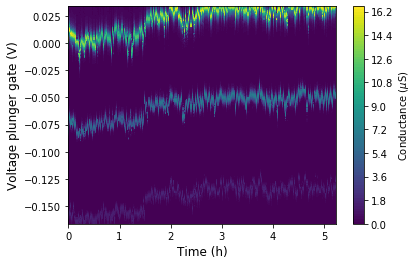

In [44]:
plotter = PlotterPlungerTimetrace3D()
plotter.max_cond = None
plotter.plot(settings, data, [node_timestamp, gates , node_r])

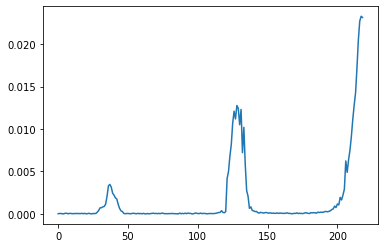

In [45]:
plt.plot(data[node_r][-15])

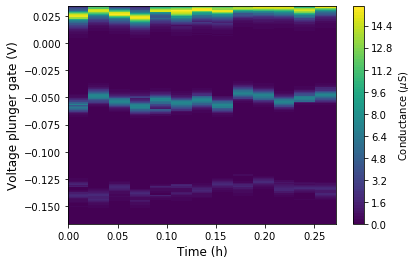

In [46]:
#%% Slice Data and Plot
slicer = SlicerPlungerTimetrace()
slicer.beginning, slicer.ending = 2.5, 2.8 # in hours
data_sliced = slicer.slice(data, [node_timestamp, gates , node_r])

plotter = PlotterPlungerTimetrace3D()
plotter.max_cond = None
plotter.savename = "plunger_timetrace_sliced"
plotter.plot(settings, data_sliced, [node_timestamp, gates , node_r])

# Let the peak hunt begin!

## The bloodmoon has risen over the city of Yharnam...

/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Number of tracked peaks: 2
Length of chosen peak track: 250
Length of samples: 250


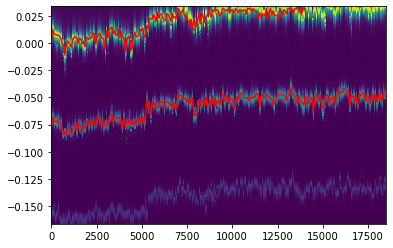

In [47]:
peak_hunter = Peak_hunt(data[node_r], data[node_timestamp], data[gates])
peak_hunter.pf.min_peak_height = 0.005
peak_hunter.pf.min_peak_width = 2
peak_hunter.pf.min_peak_distance = 30
peak_hunter.pf.fit_interval_peak_relheight = 0.9
peak_hunter.rel_jump_height = 0.5
tracked_peaks = peak_hunter.analyze()

print(f"Number of tracked peaks: {len(tracked_peaks['tracked_peak_positions'])}")
index_of_peak = 0
print(f"Length of chosen peak track: {len(tracked_peaks['tracked_peak_positions'][index_of_peak])}")
print(f"Length of samples: {len(data[node_r])}")

saver.add_info(f"{node_r}_tracked_peaks", tracked_peaks)

plt.pcolor(tracked_peaks["time_axis"], data[gates], np.transpose(data[node_r]))
for tracked_peak in tracked_peaks["tracked_peak_positions"]:
    length = min([len(tracked_peaks["time_axis"]), len(tracked_peak)])
    plt.plot(tracked_peaks["time_axis"][:length], tracked_peak[:length], color = "r")

# Spectral noise density Calculation

In [48]:
def bilinear2(x, a, b, c, switch_point):
     part1 = a * x[x <= switch_point] + b
     part2 = c * x[x > switch_point] + (a - c) * switch_point + b
     return np.concatenate((part1, part2))

4
0
2


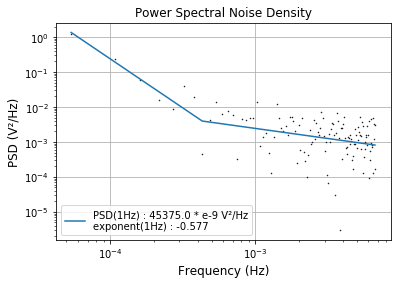

In [49]:
sampling_f = tracked_peaks["time_axis"][1]**-1
peak_no = 0
noise_calculator = AnalyzerTimetraceSpectralNoiseDensity(tracked_peaks["tracked_peak_positions"][peak_no],\
                                                        sampling_f, fit_func = bilinear2)

noise_calculator.welch_segment_length = 300
noise_calculator.guess = [-1, 1, -0.5, -3.5]
saver.add_info(f"{node_r}_peak{peak_no}_welch_segment_length", noise_calculator.welch_segment_length)
saver.add_info(f"{node_r}_peak{peak_no}_fit_interval", noise_calculator.fit_interval)

spectral_result = noise_calculator.analyze()
saver.add_info(f"{node_r}_peak{peak_no}_spectrum", spectral_result)
saver_overview.add_info(f"{node_r}_peak{peak_no}_spectrum", spectral_result)

fit = noise_calculator.fit()
saver.add_info(f"{node_r}_peak{peak_no}_SNDfit_parameters", fit)
saver_overview.add_info(f"{node_r}_peak{peak_no}_SNDfit_parameters", fit)

f, s = spectral_result["freq"], spectral_result["spectrogram"]
saving_path = os.path.join(settings["file_info"]["savepath"], node_r)

plotter_SND = PlotterTimetraceSpectralNoiseDensity(saving_path, [f,s], fit)
plotter_SND.plot()

# Jump analysis

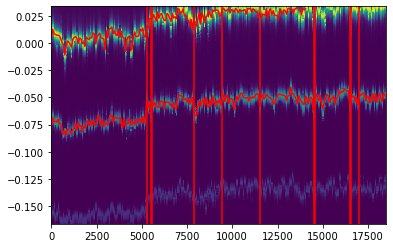

In [50]:
jump_analysis = jump_count(tracked_peaks["tracked_peak_positions"][peak_no], tracked_peaks["time_axis"])
jump_analysis.big_jump_minimum_height = 10e-3
jump_analysis.bin_count = 50
jump_analysis.range = (-0.01, 0.01)
jump_hist, big_jumps = jump_analysis.analyze()
popt = jump_analysis.fit()

saver.add_info(f"{node_r}_peak{peak_no}_jumphist", jump_hist)
saver.add_info(f"{node_r}_peak{peak_no}_big_jumps", big_jumps)
saver.add_info(f"{node_r}_peak{peak_no}_jumpfit_parameters", popt)

saver_overview.add_info(f"{node_r}_peak{peak_no}_big_jumps", big_jumps)
saver_overview.add_info(f"{node_r}_peak{peak_no}_jumpfit_parameters", fit)

plt.pcolor(tracked_peaks["time_axis"], data[gates], np.transpose(data[node_r]))
for tracked_peak in tracked_peaks["tracked_peak_positions"]:
    length = min([len(tracked_peaks["time_axis"]), len(tracked_peak)])
    plt.plot(tracked_peaks["time_axis"][:length], tracked_peak[:length], color = "r")
for jump_time in big_jumps["time_of_big_jumps"]:
    plt.axvline(jump_time, color = "r")

FHWM of the guassian distribution: 11.132976121719945 mV


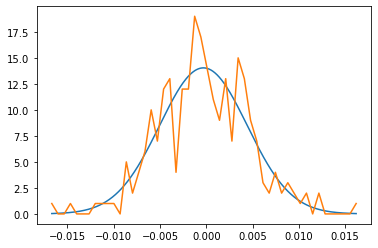

In [51]:
print(f"FHWM of the guassian distribution: {2.35482e3 * popt[-1]} mV")
x = np.linspace(min(jump_hist["jump_height"]), max(jump_hist["jump_height"]), 1000)
y = gauss_function(x, *popt)
plt.plot(x, y)
plt.plot(jump_hist["jump_height"], jump_hist["jumps_per_bin"])

# Save your analysis!

In [53]:
saver.save()

ovw = saver_overview.additional_info
if bcv not in ovw.keys():
    saver_overview.additional_info = {bcv : saver_overview.additional_info}
saver_overview.save()